In [25]:
import tensorflow as tf
import tensorflow_io as tfio
from tensorflow.keras import layers
from tensorflow.keras import models
import matplotlib
from matplotlib import pyplot as plt
import os
import pathlib
from pathlib import Path
import numpy as np
from IPython.display import display
from IPython.display import Audio
from IPython.core.display import display

/var/folders/3m/gc1133c568d2xrx9w8jnr92m0000gn/T/ipykernel_13791/3659903053.py:13: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


In [26]:
def mono_16k(wav, labels):
    #file_contents = tf.io.read_file(file_path)
    #wav ,sample_rate = tf.audio.decode_wav(file_contents, desired_channels = 1)
    wav = tf.squeeze(wav, axis = -1)
    #sample_rate = tf.cast(sample_rate, dtype= tf.int64)
    #wav = tfio.audio.resample(wav, rate_in = sample_rate, rate_out = 16000)
    return wav, labels


In [27]:
path=''
data_dir = Path(path)
commands = np.array(os.listdir(str(data_dir)))
print("COMMANDS :", commands)

COMMANDS : ['on' 'off']


In [28]:
train_data, test_data = tf.keras.utils.audio_dataset_from_directory(
    directory  = data_dir,
    #labels='inferred',
    #class_names=None,
    batch_size = 64,
    seed = 0,
    validation_split = 0.25,
    subset = "both",
    output_sequence_length = 16000
)

Found 4751 files belonging to 2 classes.
Using 3564 files for training.
Using 1187 files for validation.


In [29]:
print(train_data)

<_BatchDataset element_spec=(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [30]:
labels_list = np.array(train_data.class_names)
print(labels_list)

['off' 'on']


In [31]:
train_data = train_data.map(mono_16k, tf.data.AUTOTUNE)
test_data = test_data.map(mono_16k, tf.data.AUTOTUNE)

In [32]:
for x_audio, x_label in train_data.take(1):
    print(x_audio.shape)
    print(x_label.shape)
    

(64, 16000)
(64,)


In [33]:
waves = train_data.as_numpy_iterator().next()

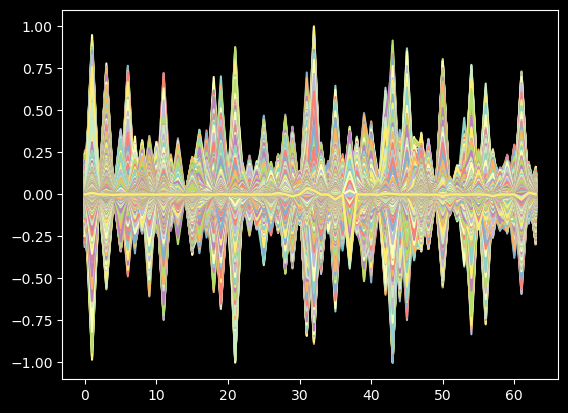

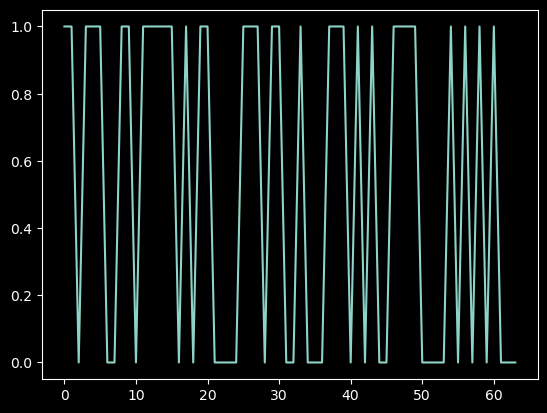

In [34]:
for wave in waves:
    
    plt.plot(wave)
    plt.show()

In [35]:
def make_spectrogram(wav):
    spectrogram = tf.signal.stft(wav, frame_length= 320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis =2)
    return spectrogram

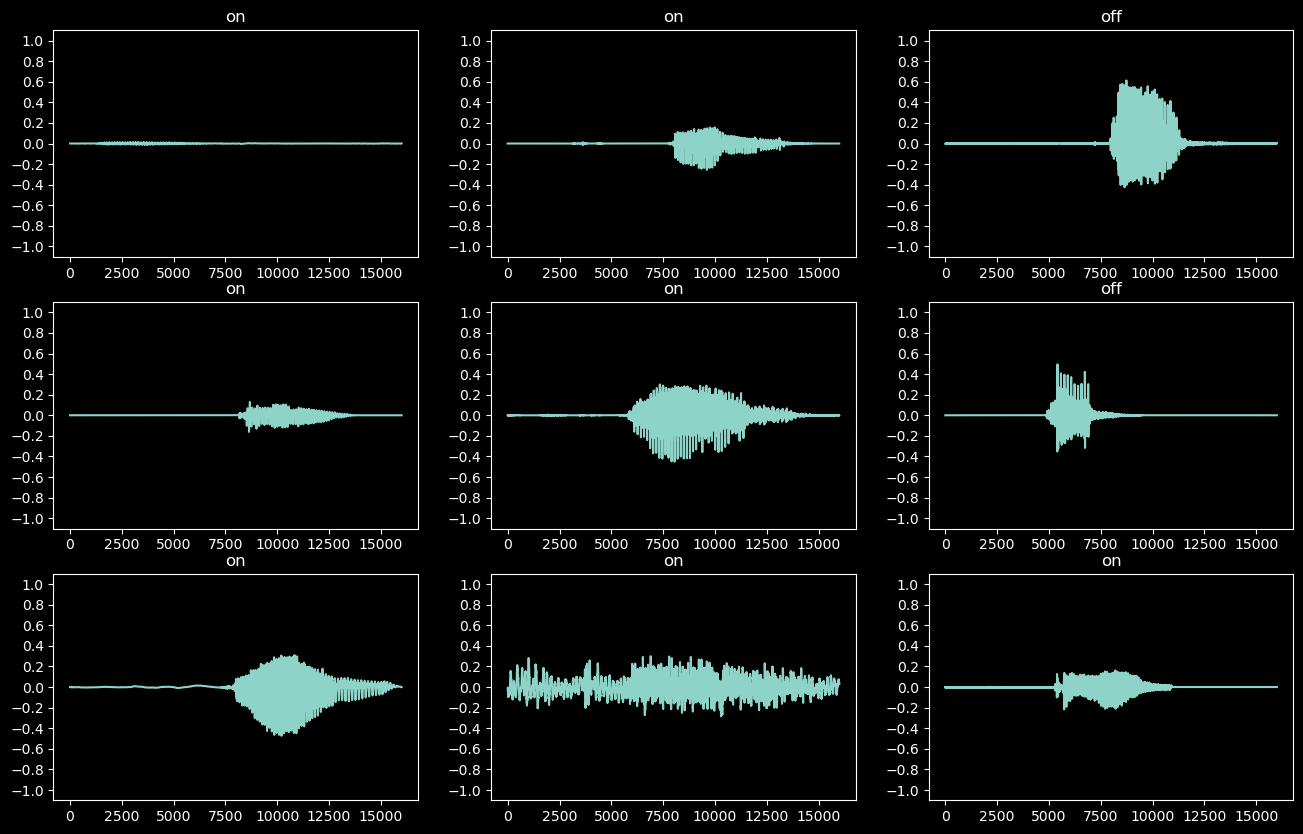

In [36]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = x_audio[i]
  plt.plot(audio_signal)
  plt.title(labels_list[x_label[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

In [37]:
for i in range(3):
  label = labels_list[x_label[i]]
  waveform = x_audio[i]
  spectrogram = make_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display(Audio(waveform, rate=16000))

Label: on
Waveform shape: (16000,)
Spectrogram shape: (491, 257, 1)
Audio playback


Label: on
Waveform shape: (16000,)
Spectrogram shape: (491, 257, 1)
Audio playback


Label: off
Waveform shape: (16000,)
Spectrogram shape: (491, 257, 1)
Audio playback


In [38]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram)
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

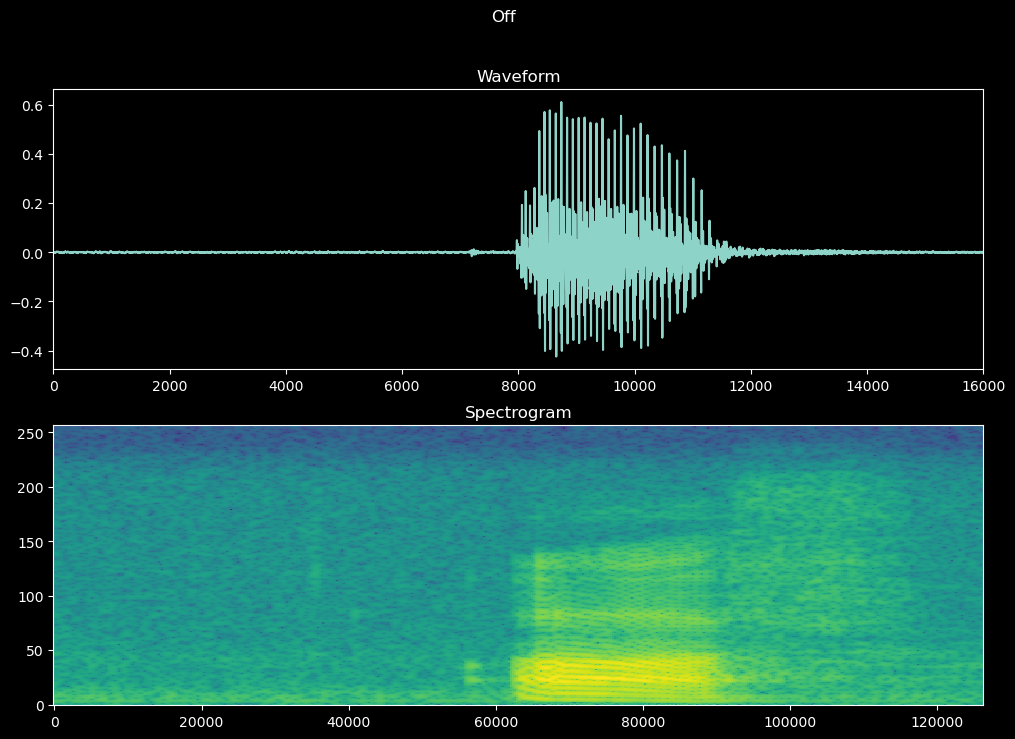

In [39]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

In [40]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (make_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [41]:
train_spectrogram_ds = make_spec_ds(train_data)
test_spectrogram_ds = make_spec_ds(test_data)

In [42]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

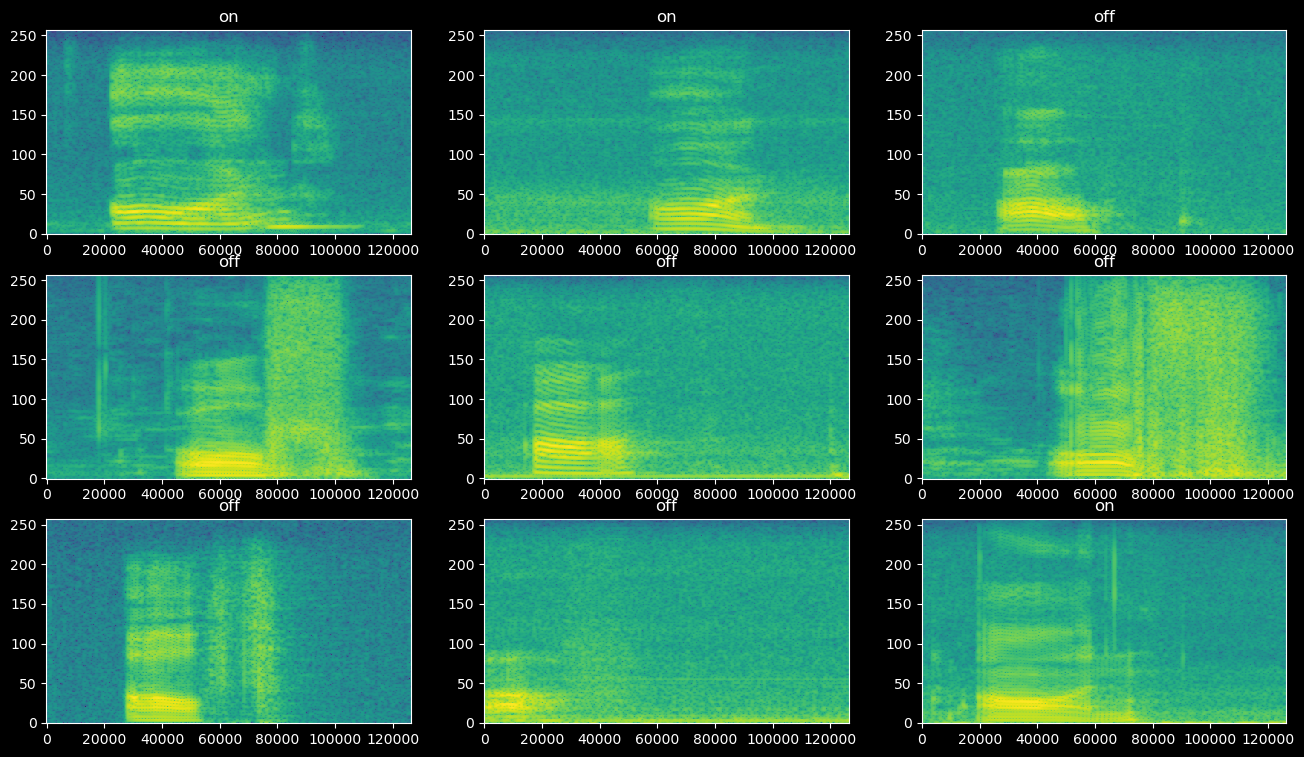

In [43]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(labels_list[example_spect_labels[i].numpy()])

plt.show()

In [44]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(labels_list)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 1, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.Conv2D(256, 5, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (491, 1, 257)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_1 (Resizing)       (None, 32, 32, 257)       0         
                                                                 
 normalization_1 (Normaliza  (None, 32, 32, 257)       515       
 tion)                                                           
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 32)        8256      
                                                                 
 conv2d_4 (Conv2D)           (None, 30, 30, 64)        18496     
                                                                 
 conv2d_5 (Conv2D)           (None, 26, 26, 256)       409856    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 13, 13, 256)       0         
 g2D)                      

In [45]:
model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [46]:
EPOCHS = 100
history = model.fit(
    train_spectrogram_ds,
    validation_data= (test_spectrogram_ds),
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/100
56/56 [==============================] - 86s 1s/step - loss: 0.9393 - accuracy: 0.6765 - val_loss: 0.4623 - val_accuracy: 0.8231
Epoch 2/100
56/56 [==============================] - 92s 2s/step - loss: 0.3852 - accuracy: 0.8510 - val_loss: 0.2991 - val_accuracy: 0.8711
Epoch 3/100
56/56 [==============================] - 88s 2s/step - loss: 0.2559 - accuracy: 0.9035 - val_loss: 0.2046 - val_accuracy: 0.9090
Epoch 4/100
56/56 [==============================] - 84s 1s/step - loss: 0.1860 - accuracy: 0.9268 - val_loss: 0.1809 - val_accuracy: 0.9191
Epoch 5/100
56/56 [==============================] - 84s 1s/step - loss: 0.1594 - accuracy: 0.9400 - val_loss: 0.1698 - val_accuracy: 0.9309
Epoch 6/100
56/56 [==============================] - 83s 1s/step - loss: 0.1371 - accuracy: 0.9425 - val_loss: 0.1789 - val_accuracy: 0.9284
Epoch 7/100
56/56 [==============================] - 85s 1s/step - loss: 0.1348 - accuracy: 0.9473 - val_loss: 0.1533 - val_accuracy: 0.9410
Epoch 8/100
5

In [47]:
model.evaluate(test_spectrogram_ds, return_dict=True)

19/19 [==============================] - 11s 451ms/step - loss: 0.1895 - accuracy: 0.9326


{'loss': 0.18954217433929443, 'accuracy': 0.9326031804084778}

In [48]:
model.save("VOICE 07_Customized.h5")